# Preparing your log file
You should be able to use your saved logfile, however if you have colorized log output from trunk-recorder, you'll need to use asci2txt from `colorized-logs` to strip those codes out.

* docker logs trunk-recorder 2> tr.log
* ansi2txt < tr.log > tr.log.log
* gzip tr.log

In [199]:
import datetime
import gzip
import re
import pandas as pd

calldict = {}
logfile = gzip.open("tr.log.gz", "rt")
# Define the regex pattern for our log entries
log_pattern = r".*\[(\S+\s\S+)\]\s+\((\S+)\)\s+\[(\S+)\]\s+(\d+).*TG:.*\((.*)\).*Freq:\s+(\d+\.\d+).*MHz\s+(.*)"
for line in logfile:
    if match := re.match(log_pattern, line):
        calldata = match[7]
        # Technically this isn't a real unixtimestamp as it's not timezone aware,
        # but we're just using it to create a unique index identifier.
        calldate = datetime.datetime.strptime(match[1], "%Y-%m-%d %H:%M:%S.%f")
        callts = calldate.timestamp()
        # Index for the dict is timestamp(ish)-talkgroup
        callindex = f"{int(callts)}-" + match[5]

        # Second round of regexp.  Now we are going to harvest data from calldata - the "everything else"
        # Yes, this does need to be refactored as a loop ...
        # Note to me, make the regexp a list, for loop it, and change continue to break
        # Not recording talkgroup. Priority is -1.
        data_pattern = r".*(Not recording talkgroup.).*"
        if datamatch := re.match(data_pattern, calldata):
            calldict[callindex] = {"excluded": True}
            calldict[callindex].update(
                {
                    "calldate": calldate,
                    "loglevel": match[2],
                    "system": match[3],
                    "callnumber": int(match[4]),
                    "talkgroup": match[5].strip(),
                    "frequency": float(match[6]),
                }
            )
            continue
        # Not Recording: ENCRYPTED - src: 3290217
        data_pattern = r".*(ENCRYPTED).*"
        if datamatch := re.match(data_pattern, calldata):
            calldict[callindex] = {"encrypted": True}
            calldict[callindex].update(
                {
                    "calldate": calldate,
                    "loglevel": match[2],
                    "system": match[3],
                    "callnumber": int(match[4]),
                    "talkgroup": match[5].strip(),
                    "frequency": float(match[6]),
                }
            )
            continue
        # Not Recording: TG not in Talkgroup File
        data_pattern = r".*(TG not in Talkgroup File).*"
        if datamatch := re.match(data_pattern, calldata):
            calldict[callindex] = {"unknown_talkgroup": True}
            calldict[callindex].update(
                {
                    "calldate": calldate,
                    "loglevel": match[2],
                    "system": match[3],
                    "callnumber": int(match[4]),
                    "talkgroup": match[5].strip(),
                    "frequency": float(match[6]),
                }
            )
            continue
        # Concluding Recorded Call - Last Update: 4s	Recorder last write:4.4819	Call Elapsed: 7
        data_pattern = r".*Call Elapsed:\s+(\d+)"
        if datamatch := re.match(data_pattern, calldata):
            calldict[callindex] = {"duration": int(datamatch[1])}
            # This log event happens at the end of a call, so we should adjust the calltime
            # back by duration seconds to get to the start.
            calldate = calldate + datetime.timedelta(seconds=-int(datamatch[1]))
            calldict[callindex].update(
                {
                    "calldate": calldate,
                    "loglevel": match[2],
                    "system": match[3],
                    "callnumber": int(match[4]),
                    "talkgroup": match[5].strip(),
                    "frequency": float(match[6]),
                }
            )

calldf = pd.DataFrame.from_dict(calldict, orient="index")
calldf.sort_values(by="calldate", inplace=True)

In [200]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option("display.max_rows", 999)
pd.set_option("display.precision", 5)
display(calldf.head().style.hide(axis="index"))

excluded,calldate,loglevel,system,callnumber,talkgroup,frequency,duration,unknown_talkgroup,encrypted
nan,2024-05-09 12:22:31.005216,info,pwcp25,1,PWFD 5B,851.962500,7.000000,nan,nan
nan,2024-05-09 12:22:31.009743,info,pwcp25,2,PWPD Central 1,852.900000,25.000000,nan,nan
True,2024-05-09 12:22:33.317803,info,pwcp25,3,PWSchBus W,852.725000,nan,nan,nan
nan,2024-05-09 12:22:35.007133,info,pwcp25,4,PWFD 5B,852.787500,14.000000,nan,nan
True,2024-05-09 12:22:36.718416,info,pwcp25,5,PWSchBus E,852.725000,nan,nan,nan


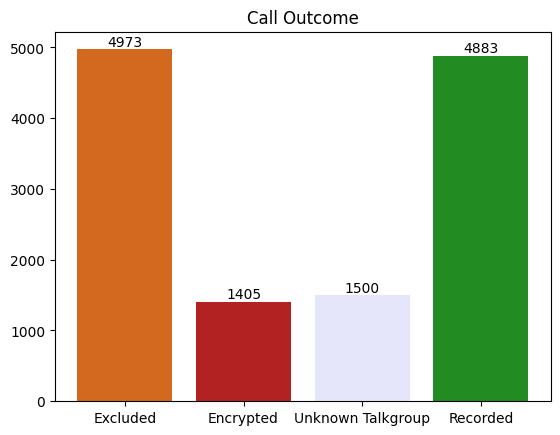

In [209]:
total_call_count = calldf.shape[0]
excluded_call_count = calldf.query('excluded == True').shape[0]
encrypted_call_count = calldf.query('encrypted == True').shape[0]
unknown_talkgroup_count = calldf.query('unknown_talkgroup == True').shape[0]
call_duration_count = calldf['duration'].notnull().sum()

average_call_duration = calldf['duration'].mean()
average_call_duration = np.round(average_call_duration,2)

# display(f"The Total Number of Calls is: {total_call_count}")
# display("Of those:")
# display(f"{excluded_call_count} were excluded, likely due to the talkgroup being excluded")
# display(f"{encrypted_call_count} were encrypted and not recorded")
# display(f"{unknown_talkgroup_count} were in an unknown talkgroup and were recorded or not based on your settings")

# display (f"The Average Call Duration is: {average_call_duration} seconds")

# Graph time!
callcounts = [excluded_call_count, encrypted_call_count, unknown_talkgroup_count, call_duration_count]
callcategories = ('Excluded', 'Encrypted', 'Unknown Talkgroup', 'Recorded')
y_pos = np.arange(len(callcategories))
bar_colors = ['chocolate', 'firebrick', 'lavender', 'forestgreen']
# Create bars
p = plt.bar(y_pos, callcounts, color=bar_colors)
plt.bar_label(p) # This puts the number on the top of each bar
plt.title("Call Outcome")
# Create names on the x-axis
plt.xticks(y_pos, callcategories)
# Show graphic
plt.show()



In [210]:
#calldf['frequency'].value_counts()
frequency_counts = calldf['frequency'].value_counts()
display(frequency_counts)

#plt.stem(frequency_counts.index, frequency_counts.values)
#plt.show()

frequency
851.4750    1974
852.7250    1912
851.4500    1865
853.1750    1095
851.7000    1041
851.7250    1027
852.9000    1018
851.9875     963
852.7875     931
851.9625     919
851.1750       8
853.9500       5
853.6250       3
Name: count, dtype: int64